In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rand

In [2]:
r = 0.05

In [3]:
def coarse_grain(series, resolution):
    out_len = int(len(series)/resolution)
    out = np.empty([out_len, 1])
    for i, subarray in enumerate(np.split(series, out_len)):
        out[i] = np.mean(subarray)
    return out
    

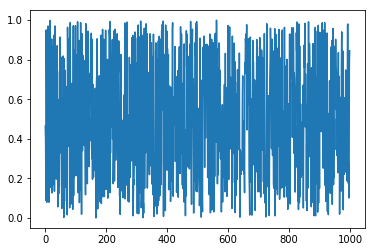

In [4]:
series = np.random.random(1000)
plt.plot(series)
plt.show()

10


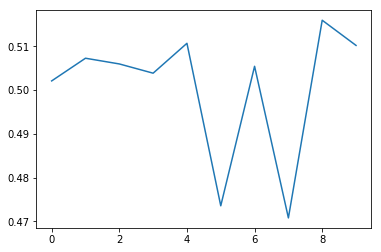

In [5]:
y2 = coarse_grain(series, 100)
print(len(y2))
plt.plot(y2)
plt.show()


Here's what the next function implements:

$$SampEn(m,r,N,i) = -\ln(\frac{A}{B})$$

$$A = \frac{(N-m-1)(N-m)}{2}A^m(r)$$

$$B = \frac{(N-m-1)(N-m)}{2}B^m(r)$$

$$A^m(r) = \frac{\sum^{N-m}_{i=1}A^m_i(r)}{N-m}$$

$$B^m(r) = \frac{\sum^{N-m}_{i=1}B^m_i(r)}{N-m}$$

$$A^m_i(r) = \frac{X_{m+1, i}}{(N-m-1)}$$

$$B^m_i(r) = \frac{X_{m, i}}{(N-m-1)}$$

where $X_m(i)$ is the number of vectors that match the vector of length $m$ beginning at $i$


In [10]:
def count_matches(sequence, template_start, template_length, r):
    """Counts matches of length m, ignoring the first instance"""
    # For now, return values from example. This will need to be modified later.
    if template_length == 2:
        return 3
    if template_length == 3:
        return 1

def sample_entropy(sequence, m, r):
    N = len(sequence)
    A_m_i_sum = 0
    B_m_i_sum = 0
    try:
        for i in range(0, N-m):  # The paper is 1 indexed, but this shouldn't be a problem 
            X_m = count_matches(sequence, template_start=i, template_length=m, r=r)
            X_m_plus_1 = count_matches(sequence, template_start=i, template_length=m+1, r=r)
            A_m_i = X_m_plus_1/(N-m-1)
            B_m_i = X_m/(N-m-1)
            A_m_i_sum += A_m_i
            B_m_i_sum += B_m_i
        A_m = A_m_i_sum/(N - m)
        B_m = B_m_i_sum/(N - m)
        coef = ((N - m - 1)*(N - m))/2
        A = coef*A_m
        B = coef*B_m
        out = -1*np.log(A/B)
    except ZeroDivisionError:
        return -1
    if out == np.inf:
        return -2
    return out

In [11]:
#This should return 1.09, when the above monkeypatch is used.
foo = sample_entropy(sequence=y2, m=2, r=0.1)
print(foo)

1.0986122886681098


In [12]:
def count_matches(sequence, template_start, template_length, r):
    template = sequence[template_start:template_start+template_length]
    count = 0
    for i in range(len(sequence) - template_length):
        if i is template_start:
            continue
        if np.allclose(template, sequence[i:i+template_length], atol=(r), rtol=0):
            count = count + 1
    return count

Note for above function; uses numpy.allclose to test if two arrays are within r. This seems to apply the following element-wise formula: $$absolute(a - b) < (atol + rtol * absolute(b))$$

This seems to differ from the Numpy documentation, which says the comparison is $<=$; see appendix cells.

I haven't taken any steps to remedy this yet; it might lead to a small change detected entropy in very coarse data, but in pretty much every case this library is used for it shouldn't matter. It may affect testing; let's keep an eye on it.

I'll need to think if the tolerance in above should be implemented as $r$, $r/2$ or $r*2$

There's further gains to be made here by applying signal processing techniques (kernel corellation functions)

In [13]:
# This should return 2
sequence = [0.9,2.1,2.9,4.1,1.1,1.9,3.1,0.9,2.1,1.1]
count_matches(sequence, template_start=4, template_length=2, r=0.21)

2

In [15]:
# Re-'importing' sample_entropy from above to put the proper count_matches function in.
def sample_entropy(sequence, m, r):
    N = len(sequence)
    A_m_i_sum = 0
    B_m_i_sum = 0
    try:
        for i in range(0, N-m):  # The paper is 1 indexed, but this shouldn't be a problem 
            X_m = count_matches(sequence, template_start=i, template_length=m, r=r)
            X_m_plus_1 = count_matches(sequence, template_start=i, template_length=m+1, r=r)
            A_m_i = X_m_plus_1/(N-m-1)
            B_m_i = X_m/(N-m-1)
            A_m_i_sum += A_m_i
            B_m_i_sum += B_m_i
        A_m = A_m_i_sum/(N - m)
        B_m = B_m_i_sum/(N - m)
        coef = ((N - m - 1)*(N - m))/2
        A = coef*A_m
        B = coef*B_m
        out = -1*np.log(A/B)
    except ZeroDivisionError:
        # I think this is due to N-m-1 == 0; so, the edge case
        return -1
    if out == np.inf:
        # I think this is due to count_matches not finding any match, hence A_m = 0/(N-m) = inf
        return -2
    return out

I suspect there's many, *many* optimisations that can be made at the macro scale for this; instead of calculating everying basically sequentially, I suspect we could clump certain operations such as pre-calculating the X_m values for every i and m, and storing the result in a lookup table. This would save some calculations and we could probably do smart and attractive things with memory - ut that can come later.

[4, 5, 8, 10, 16, 20, 25, 40, 50, 80, 100, 125, 200, 250, 400, 500, 625, 1000, 1250, 2000, 2500, 5000]
1.631679506625302
1.5164596709204021
1.2714097944509863
1.189827855478248
0.9771395193661723
0.8841728660585965
0.756969027744591
0.5717583456582153
0.4631109362250755
0.3147734181189682
0.2003354417690147
0.14667492232651388
0.0843811092721345
0.06311242331005629
0.04481401578979254
0.05715841383994864
0.07410797215372172
0.13353139262452274
0.1823215567939546
0.40546510810816444
0.6931471805599453
-1


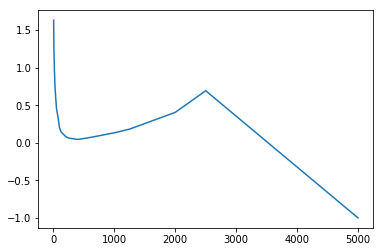

In [24]:
sequence = np.random.random([10000])
mse_scales = [x for x in range(3,len(sequence)) if len(sequence)%x == 0]
print(mse_scales)
mse = np.empty_like(mse_scales, dtype=np.float)
for i, scale in enumerate(mse_scales):
    coarse_sequence = coarse_grain(sequence, scale)
    foo = sample_entropy(coarse_sequence, m=2, r = 0.05)
    print(foo)
    mse[i] = foo
plt.plot(mse_scales, mse)
plt.show()

From running the above, it's pretty obvious that this is too slow to be practical for geospatial applications right now. (it takes about 20 minutes to run for a list of 10000 on my home desktop). The first target for optimisation is going to be a rework of the count_matches function; as it is, we're couting all the matches of length (m) then all the matches of length (m+1); which is rubbish, as a match can't be in (m+1) without being in (m) first. I think there are further steps to be taken here wit hregards to looking at every length m thing as well.

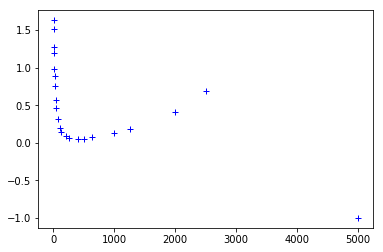

In [27]:

plt.plot(mse_scales, mse, 'b+')
plt.show()

The graph profile we can see above is the result of running the simulation on a random noise sample of 10000 points. According to the original paper, white noise shows a log decrease en entropy as m increases; I think that the only reason we're note seeing that here is because the coarseness of the grain means that the randomness of white noise comes to dominate. If we're using this for actual analysis, we'll want to pick where we cut off.

**Appendix 1: np.allclose uncertainty**
See the comparison of outputs of the below functions as an illustration of the allclose issues.

In [126]:
spam = [0.9, 2.1]
eggs = [1.1, 1.9]
np.allclose(spam, eggs, atol=0.2+1e-10, rtol=0)

True

In [127]:
np.allclose(spam, eggs, atol=0.2, rtol=0)

False